In [1]:
import quantstats as qs
print(qs.__version__)


0.0.59


In [1]:
import os
import pickle
import pandas as pd
import pandas_ta as ta
import numpy as np
import yfinance as yf
import vectorbt as vbt
import matplotlib.pyplot as plt

import seaborn as sns
sns.set()
import quantstats as qs
qs.extend_pandas()

from joblib import Parallel, delayed
from itertools import combinations
from itertools import product

import warnings
warnings.filterwarnings('ignore')

In [2]:
def get_data_from_yfinance(pool: list) -> pd.DataFrame:
    ohlc_df = yf.download(pool, ignore_tz=True)
    Adj_rate = ohlc_df['Adj Close']/ohlc_df['Close']
    for column in ['Close', 'Open', 'High', 'Low']:
        ohlc_df[column] *= Adj_rate
        ohlc_df[column] = ohlc_df[column].ffill()  # Fill forward 
    
    # Filter the DataFrame to include only the requested tickers
    return ohlc_df.loc[:, (slice(None), pool)]

In [3]:
target_symbol = ['VLUE', # iShares MSCI USA Value Factor ETF
                 'SIZE', # iShares MSCI USA Size Factor ETF
                 'MTUM', # iShares MSCI USA Momentum Factor ETF
                 'USMV', # iShares Edge MSCI Min Vol USA ETF
                 'QUAL', # iShares Edge MSCI USA Quality Factor ETF
                 'VYM', # Vanguard High Dividend Yield ETF
                 'VUG' # Vanguard Growth ETF
                 ]
benchmark_symbol = ['SPY']

data = target_symbol + benchmark_symbol


In [4]:
ohlc_df = get_data_from_yfinance(data)
ohlc_df = ohlc_df.dropna()
returns = ohlc_df['Close'].pct_change().dropna()
expretunrs = ohlc_df['Open'][target_symbol].pct_change().shift(-2)
benchmark = returns[benchmark_symbol].squeeze()

[*********************100%%**********************]  8 of 8 completed


In [66]:
extra_returns = returns[target_symbol].sub(benchmark, axis=0)
rolling_returns = extra_returns.rolling(window = 80).sum()

In [67]:
sign_df = rolling_returns.applymap(lambda x: 0 if x <= 0 else x) # if rolling_return < 0 than we dont buy it

In [68]:
weight = sign_df.div(sign_df.abs().sum(axis=1), axis=0)

In [69]:
nofee_result = weight * expretunrs

Annual_ret: 0.14
Sharpe: 0.89


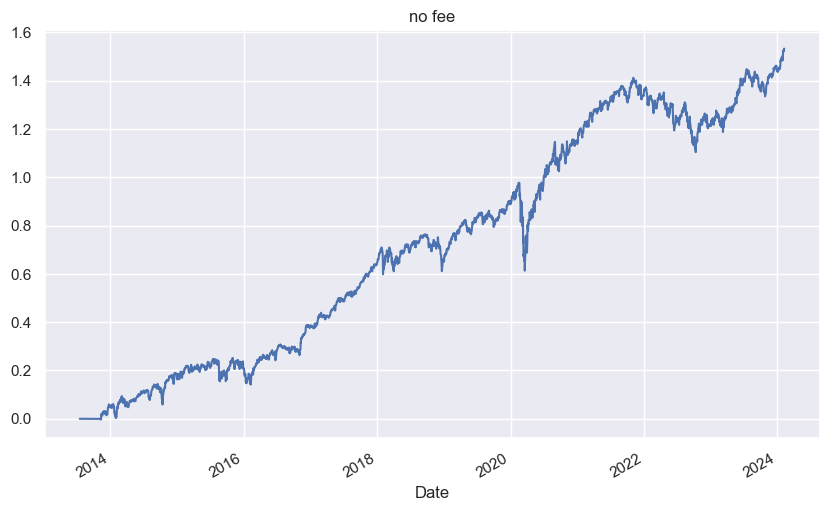

In [36]:
nofee_pnl = nofee_result.sum(axis = 1).dropna()
nofee_pnl.cumsum().plot(title = 'no fee')
annual_return = (1 + nofee_pnl).prod()**(252 / len(nofee_pnl)) - 1
sharpe = nofee_pnl.sharpe(periods=252)

print(f'Annual_ret: {annual_return:.2f}')
print(f'Sharpe: {sharpe:.2f}' )

In [62]:
frequent = 'D' # 'D','W','M'

if frequent =='D':
    freq_sign_df = sign_df # signal_df, monthly_df
elif frequent =='W':
    freq_sign_df = sign_df.resample('W').last()
elif frequent =='M':
    freq_sign_df = sign_df.resample('M').last()

full_date_index = pd.date_range(start=sign_df.index.min(), end=freq_sign_df.index.max(), freq='D')
freq_sign_df = freq_sign_df.reindex(full_date_index).ffill()
freq_sign_df = freq_sign_df.reindex(sign_df.index,method='ffill')
freq_sign_df

Ticker,VLUE,SIZE,MTUM,USMV,QUAL,VYM,VUG
Date,,,,,,,
2013-12-31,0.0,0.000000,0.015305,0.0,0.011843,0.0,0.008717
2014-01-02,0.0,0.000000,0.015305,0.0,0.011843,0.0,0.008717
2014-01-03,0.0,0.000000,0.015305,0.0,0.011843,0.0,0.008717
2014-01-06,0.0,0.000000,0.015305,0.0,0.011843,0.0,0.008717
2014-01-07,0.0,0.000000,0.015305,0.0,0.011843,0.0,0.008717
...,...,...,...,...,...,...,...
2024-02-02,0.0,0.000875,0.049981,0.0,0.005651,0.0,0.020589
2024-02-05,0.0,0.000875,0.049981,0.0,0.005651,0.0,0.020589
2024-02-06,0.0,0.000875,0.049981,0.0,0.005651,0.0,0.020589


# 萬五 萬八 萬九

In [73]:
AUM = 2000000

freq_sign_df = freq_sign_df.dropna()
start_time = freq_sign_df.index[0]
end_time = freq_sign_df.index[-1]

sign_df = freq_sign_df.loc[start_time:end_time]
expreturn = expretunrs.loc[start_time:end_time]

weight = freq_sign_df.div(sign_df.abs().sum(axis=1), axis=0)

# the signal will become weight and buy at tomorrow market open
number_of_shares = ((AUM*weight) // (ohlc_df['Open'].shift(-1)))* ohlc_df['Open'].shift(-1) /AUM 
number_of_shares

delta_shares = number_of_shares.shift(1) - number_of_shares
delta_transaction = number_of_shares * ohlc_df['Open']  # For example, $5000

# Fixed fees
commission_per_share = 0.005  # Commission per share
Finra_trading_activity_fee_per_share = 0.000119

# Optional fees
transaction_fee_per_dollar = 0.0000221  # Applicable only for sell orders

# Calculate total additional costs
total_commission = number_of_shares * commission_per_share
Finra_fee = number_of_shares * Finra_trading_activity_fee_per_share

# Add transaction fee for sell orders
transaction_fee = delta_transaction[delta_shares < 0] * transaction_fee_per_dollar

total_additional_costs = total_commission + transaction_fee + Finra_fee

daily_fee = total_additional_costs.sum(axis = 1)
daily_profit = (weight * expreturn).sum(axis=1)
daily_returns = daily_profit - daily_fee


                           Strategy
-------------------------  ----------
Start Period               2013-12-31
End Period                 2024-02-08
Risk-Free Rate             0.0%
Time in Market             100.0%

Cumulative Return          -99.98%
CAGR﹪                     -43.64%

Sharpe                     -4.6
Prob. Sharpe Ratio         0.0%
Smart Sharpe               -4.19
Sortino                    -5.12
Smart Sortino              -4.67
Sortino/√2                 -3.62
Smart Sortino/√2           -3.3
Omega                      0.43

Max Drawdown               -99.98%
Longest DD Days            3690
Volatility (ann.)          17.7%
Calmar                     -0.44
Skew                       -0.69
Kurtosis                   6.81

Expected Daily %           -0.33%
Expected Monthly %         -6.6%
Expected Yearly %          -50.33%
Kelly Criterion            -49.43%
Risk of Ruin               0.0%
Daily Value-at-Risk        -2.16%
Expected Shortfall (cVaR)  -2.16%

Max Consecutive

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2014-01-02,2024-01-30,2024-02-08,3690,-99.977961,-99.976665


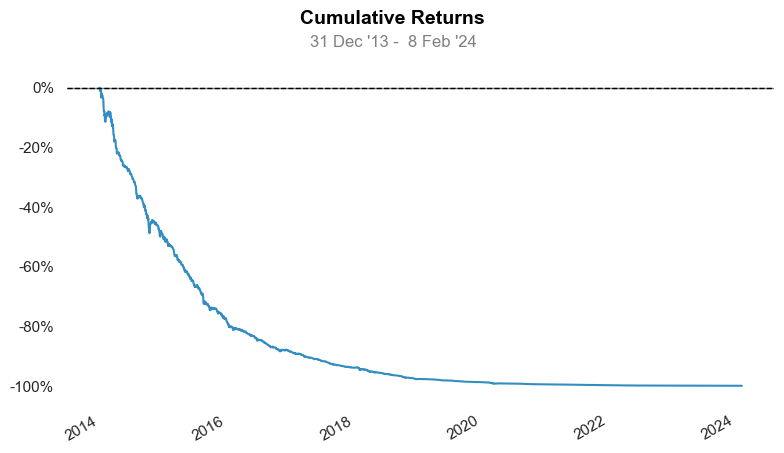

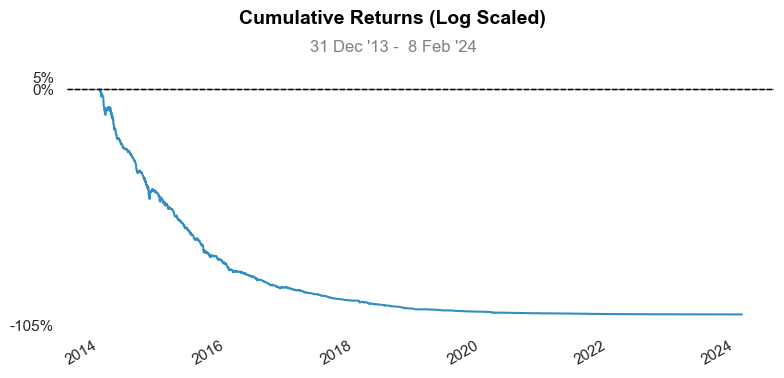

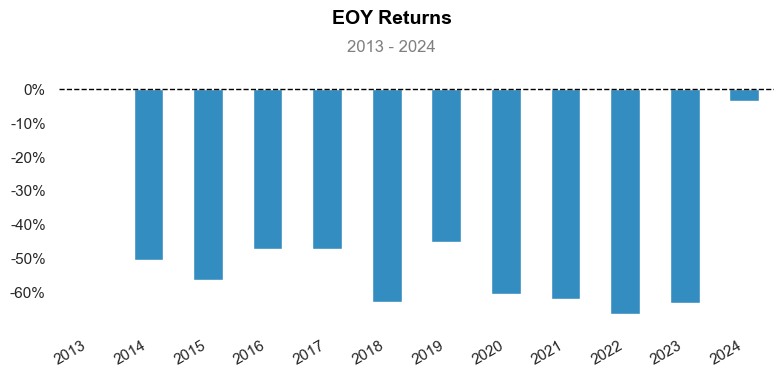

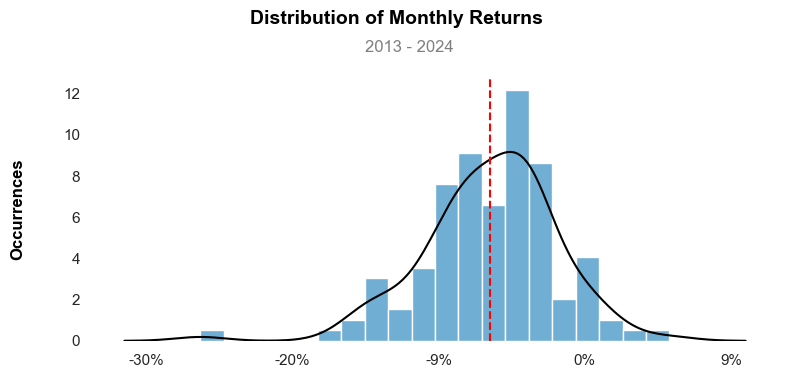

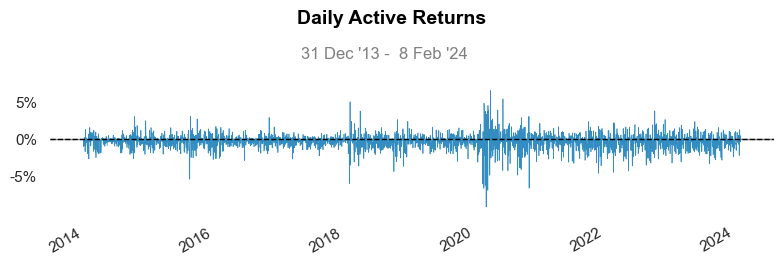

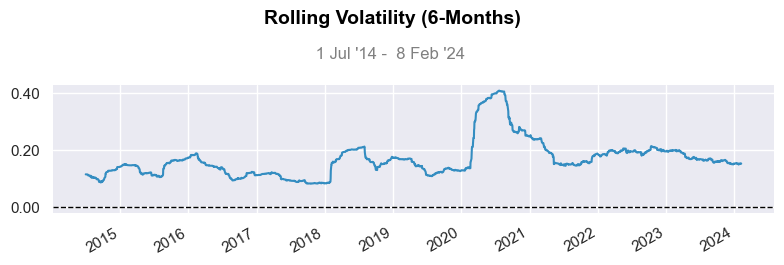

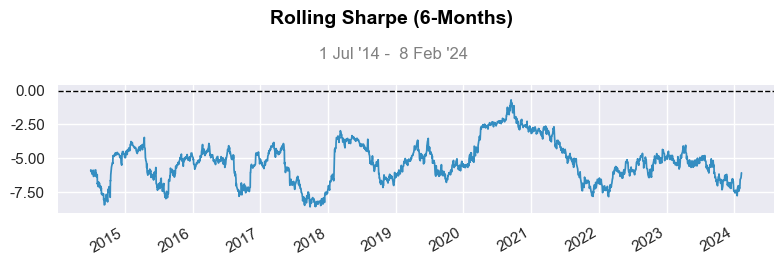

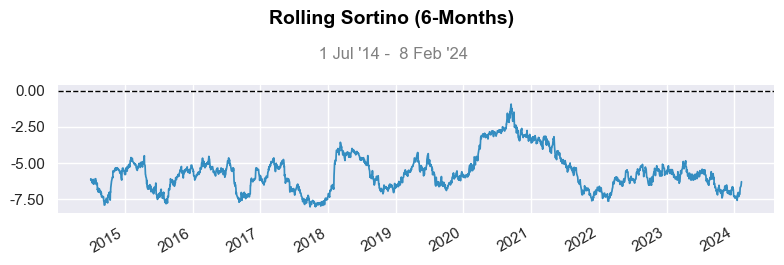

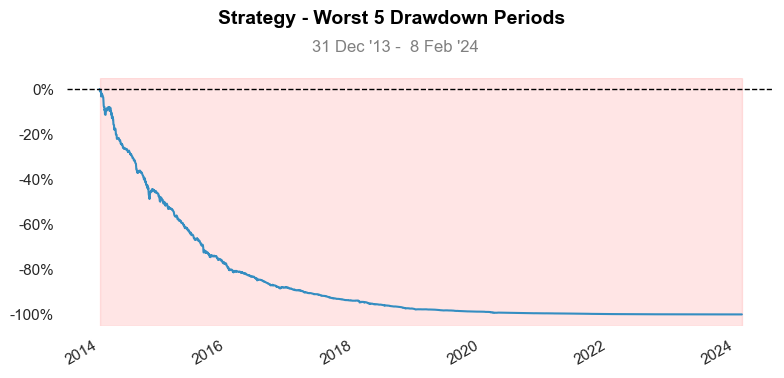

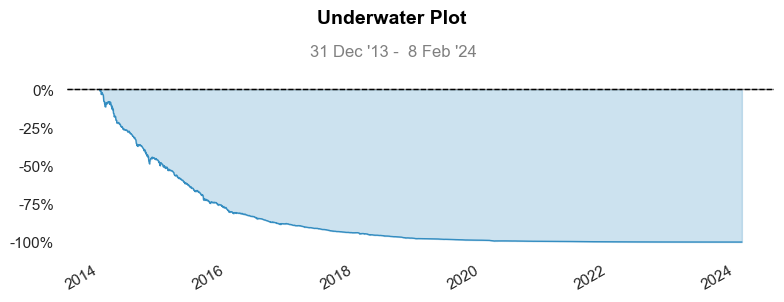

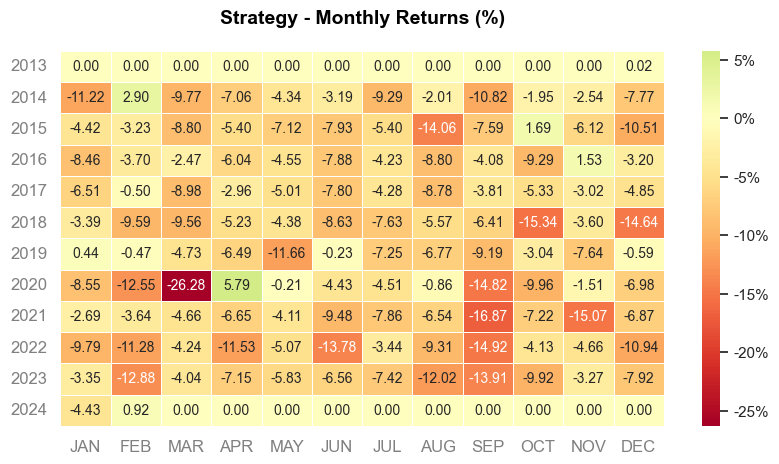

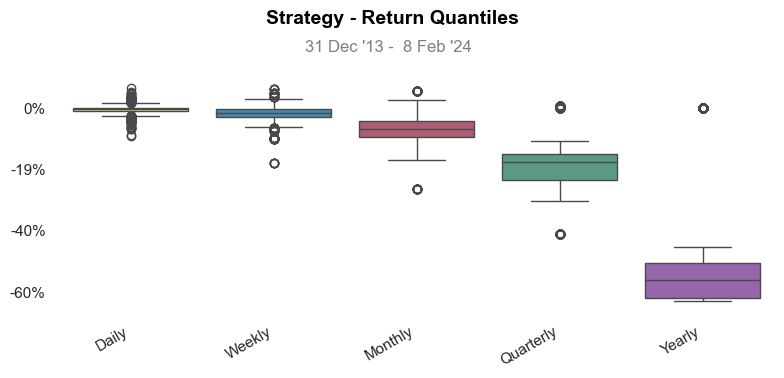

In [74]:
qs.reports.full(daily_returns, periods_per_year=252)